# AE sensor calibration using ARX model

This notebook compute the ARX model with least square method associated with the input and output waveforms.


To run this notebook, you need

- MATLAB R2020b or later
- jupyter lab (**NOTE:** do NOT open with the jupyter notebook, otherwise you will get an error.)
- jupyter-matlab-proxy (https://github.com/mathworks/jupyter-matlab-proxy)
- Signal Processing Toolbox

See [the installation guide of MATLAB kernel for jupyter notebook](https://github.com/mathworks/jupyter-matlab-proxy#installation).

**NOTE:** You need to export a path to the executable file of MATLAB such as `/Applications/MATLAB_R2021b.app/bin/matlab` to run it from the terminal.


**NOTE:** The `data` and `code` directories are searched by the relative path. Please make sure you are in the repository of `AEsensor_Calibration_ARX`. You can use `pwd` command in the cell to check the current directory.

# Theory

The ARX model is written as follows (Kay and Marple 1981; McLaskey and Glaser, 2012):
$$ y_k = \sum_{q=0}^{n} b_q u_{k-q} - \sum_{p=1}^{m} a_p y_{k-p} + w_k $$
where $y_k$ and $u_k$ $(k=0, 1, \cdots, N)$ are the discrete time series associated with the output and input of the system, respectively. $a_p$ and $b_q$ are the coefficients of ARX model, and $w_k$ indicates the white noise.

We compare the waveforms radiated from an impulsive source of transducer recorded with the Laser Doppler Vibrometer (LDV) and AE sensor, which is denoted as the input and output signals, respectively. We assume the LDV measures the true motion of the surface, and the motion is "input" to the AE sensor, which converts the motion to the voltage as the "output". 

The model parameters are estimated using least square method such that

$$\mathbf{\hat{\theta}} = \left(\sum_{k=0}^{N} \mathbf{\phi}_k \mathbf{\phi}_k^T\right)^{-1} \sum_{k=0}^{N} \mathbf{\phi}_k y_k,$$

where

$$ \mathbf{\theta} = [-a_1, -a_2, \cdots, -a_m, b_0, b_1, b_2, \cdots, b_n]^T, $$
$$ \mathbf{\phi}_k = [y_{k-1},y_{k-2}, \cdots, y_{k-m}, u_k, u_{k-1},u_{k-2}, \cdots, u_{k-n}]^T. $$

See the references on the derivation of the $\mathbf{\hat{\theta}}$. This algorithm is implemented in the `lsq_arx.m`.

The order of the model, i.e. the number of $m$ and $n$, can be chosen by the comparison of AIC (Akaike, 1974) with different model orders. In this notebook, however, we use a given number for the sake of simplicity. 


The transfer function by the ARX model can be rewritten with the z-transform such as
$$ y_k = G(z)u_k,$$
$$ G(z) = \dfrac{b_0 + b_1 z^{-1} + \cdots + b_n z^{-n}}{1 + a_1z^{-1} + \cdots + a_mz^{-m}},$$
$$ =  k\dfrac{(z-z_1)(z-z_2)\cdots(z-z_n)}{(z-p_1)(z-p_2)\cdots(z-p_m)},$$
where $p_p, z_q, k$ are the poles and zeros (PAZ), and gain of the transfer function. See the Appendix C in the manual of SEED.
We convert the $a, b$ to the PAZ coefficients using the Matlab function [`tf2zpk`](https://www.mathworks.com/help/signal/ref/tf2zpk.html).

We save the PAZ coefficients in the end of this notebook, and use them to remove the instrumental response in `02_Apply_removalresp_to_AEevent.ipynb`.

**Reference:**

[1]	Kay, S. M. and Marple, S. L. Spectrum analysis---a modern perspective. Proceedings of the IEEE, 69(11):1380-1419, 1981, doi:[10.1109/PROC.1981.12184](https://ieeexplore.ieee.org/document/1456452).

[2]	McLaskey, G. C. and Glaser, S. D. Acoustic emission sensor calibration for absolute source measurements. Journal of Nondestructive Evaluation, 31(2):157--168, 2012, doi:[10.1007/s10921-012-0131-2](https://link.springer.com/article/10.1007/s10921-012-0131-2).

[3] IRIS, SEED reference manual international federation of digital seismograph networks. 2012, URL: [http://www.fdsn.org/pdf/SEEDManual_V2.4.pdf](http://www.fdsn.org/pdf/SEEDManual_V2.4.pdf).


[4] 橋本 洋志, Scilabで学ぶ統計・スペクトル解析と同定, オーム社, 2008, ISBN: [978-4-274-20619-1](https://www.ohmsha.co.jp/book/9784274206191/) (Japanese)


# Minimal working example of computing the poles and zeros

In [1]:
clear all;
addpath("../src");

## Set parameters

In [2]:
fs = 1e7; % sampling frequency
tlen = 100e-6; % [s] data length % master data with 100 us
NT = round(tlen * fs)+1; % npts of data

% bandpass filter before applying lsq method
fmin = 0.2e5; %[Hz]
fmax = 2e5; %[Hz]

% Order of ARX model
Na = 24; % order of Auto-regressive model
Nb = 11; % order of Moving-average associated with the input


## Read the waveform data

In [3]:
LDV = readtable("../data/LDV_fronttop_S200V.csv"); % used as input
AE = readtable("../data/AE_fronttop_S100V.csv"); % used as output

In [4]:
% Store data to the structure
S.t = LDV.t;
S.LDV = LDV.LDV/1.79; % As the source is 200V on LDV while 100V on AE, devide LDV by 1.79 from linearity analysis.
S.AE = AE.AE;

In [5]:
% Trim the waveform
u_input_raw = S.LDV(1:NT); % exgeneous input data
y_output_raw = S.AE(1:NT); % output data
tvec = S.t(1:NT)*1e6; % [micro s] trimmed time vector 

In [6]:
% butterworth filter
[b,a]=butter(3, [fmin,fmax]/(fs/2),'bandpass'); % Master data: chose 3rd order.

% detrend
u_input_raw_demean = detrend(u_input_raw - mean(u_input_raw(1:100)));
y_output_raw_demean = detrend(y_output_raw - mean(y_output_raw(1:100)));

% tapered
u_input_raw_tapered = u_input_raw_demean.*tukeywin(NT,0.1);
y_output_raw_tapered = y_output_raw_demean.*tukeywin(NT,0.1);

% bandpass filtered
u_input_filtered = filter(b, a, u_input_raw_tapered);
y_output_filtered = filter(b, a, y_output_raw_tapered);

% tapered
u_input_filtered = u_input_filtered.*tukeywin(NT,0.1);
y_output_filtered = y_output_filtered.*tukeywin(NT,0.1);

u_input = u_input_filtered;
y_output = y_output_filtered;


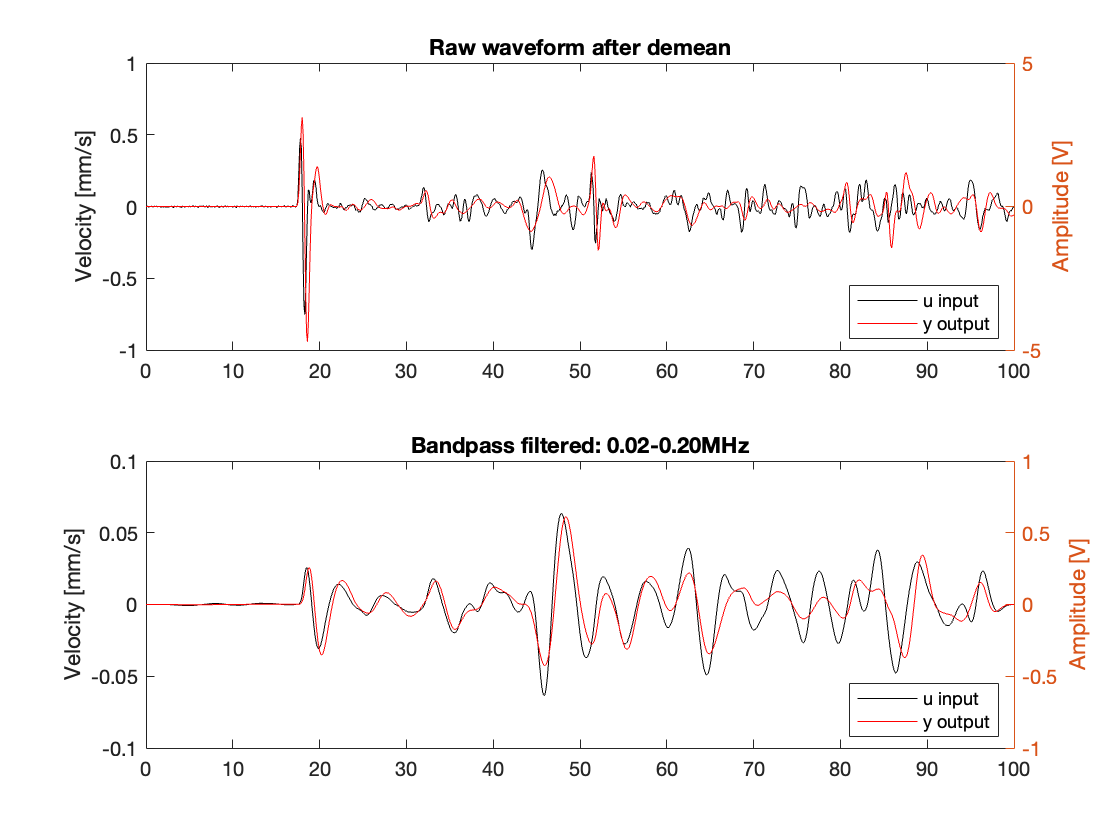

In [7]:
% Check the waveforms
clf;

subplot(211); hold on; box on;
plot(tvec, u_input_raw_demean*1e3, "k-", "DisplayName", "u input");
ylim([-1, 1]);
ylabel("Velocity [mm/s]");

yyaxis right
plot(tvec, y_output_raw_demean, "r-", "DisplayName", "y output");
ylim([-5, 5]);
ylabel("Amplitude [V]");
legend('Location','southeast');
title("Raw waveform after demean");
%-------------------------------------------%
subplot(212); hold on; box on;
plot(tvec, u_input*1e3, "k-", "DisplayName", "u input");
ylim([-0.1, 0.1]);
ylabel("Velocity [mm/s]");

yyaxis right
plot(tvec, y_output, "r-", "DisplayName", "y output");
ylim([-1, 1]);
ylabel("Amplitude [V]");
legend('Location','southeast');
title(sprintf("Bandpass filtered: %4.2f-%4.2fMHz", fmin/1e6, fmax/1e6));

set(gcf, 'Color', 'w');
figname = sprintf("../figure/input_and_output_waveforms.png");
exportgraphics(gcf, figname);

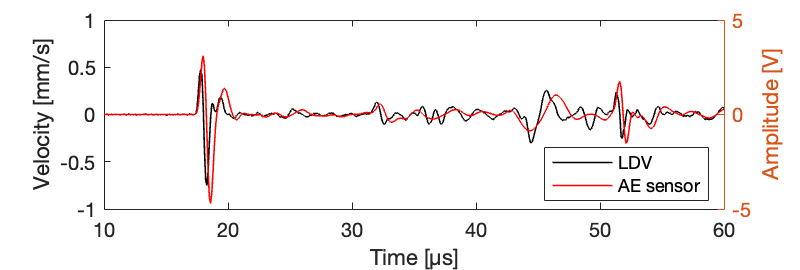

In [8]:
% Check the waveforms
clf;

fig = figure(1); clf; hold on; box on;
fig.Units = 'point';
fig.Position = [0 800 400 135]; hold on; box on;
plot(tvec, u_input_raw_demean*1e3, "k-", "DisplayName", "LDV", "LineWidth", 0.8);
ylim([-1, 1]);
ylabel("Velocity [mm/s]");

yyaxis right
plot(tvec, y_output_raw_demean, "r-", "DisplayName", "AE sensor", "LineWidth", 0.8);
ylim([-5, 5]);
xlabel("Time [μs]");
ylabel("Amplitude [V]");
legend('Location','southeast');
%title("Raw waveform after demean");
xlim([10, 60]);
set(gcf, 'Color', 'w');
figname = sprintf("../figure/input_and_output_waveforms_forslide.png");
exportgraphics(gcf, figname);

## Compute the ARX model using least square method

NOTE: We normalize the amplitude of the waveforms by their standard deviations for the sake of stability in the estimation with lsq. Therefore, we need to rescale the factor when using the poles, zeros and the gain. 

In [9]:
% scaling amplitude with std
scaling_u = std(u_input);
scaling_y = std(y_output);
u_input_scaled = u_input./scaling_u;
y_output_scaled = y_output./scaling_y;
u_normfact = scaling_u/scaling_y; % multiply this to the normalized output

In [10]:
[theta, AIC] = lsq_arx(u_input_scaled, y_output_scaled, Na, Nb); % see lsq_arx.m for the details.

In [11]:
% Dump the data for the test
save("../data/testdata_lsq_arx.mat", "u_input_scaled", "y_output_scaled", "theta", "AIC");

## Plot the distribution of poles and zeros

k = 894.9910

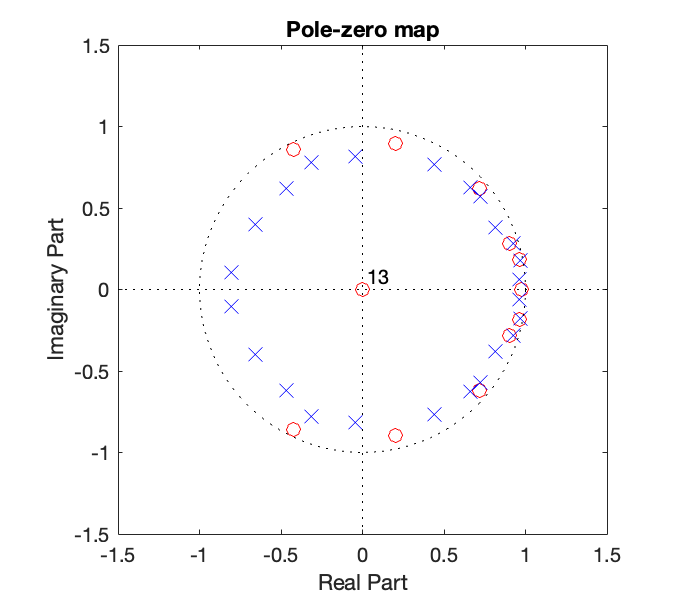

In [12]:
%%
tf_a = [1; theta(1:Na)]; % assuming a0 is 1
tf_b = theta(Na+1:end);
[z,p,k1] = tf2zpk(tf_b,tf_a);

% We rescale the scaling factor k by u_normfact
k = k1/u_normfact

%% Plot pole and zeros
fig = figure(1); clf; hold on; box on;
fig.Units = 'point';
fig.Position = [0 800 350 300];

[hz1, hp1, ht1] = zplane(z, p);%with the unit circle
set(findobj(hz1, 'Type', 'line'), 'Color', 'r'); 
set(findobj(hp1, 'Type', 'line'), 'Color', 'b');
set(findobj(ht1, 'Type', 'line'), 'Color', 'k');
% legend({"zeros", "poles", ""})

xlim([-1.5, 1.5]);
ylim([-1.5, 1.5]);
title('Pole-zero map') 
set(gcf, 'Color', 'w');
figname = sprintf("../figure/pzplot.png");
exportgraphics(gcf, figname);

## Dump the data of poles and zeros

In [13]:
save("../data/AE_resp_dataandcoef_fronttop.mat", "u_input_raw", "y_output_raw", "tf_a", "tf_b", "z",...
    "p", "k", "Na", "Nb", "AIC", "u_normfact");

Please go to next notebook (`02_Apply_removalresp_to_AEevent.ipynb`) to apply the poles and zeros to the AE waveforms.